# Inference Notebook for VizWiz VQA

In [1]:
cd ..

/Users/zagaraa/Documents/GitHub/visionaid-vqa


/Users/zagaraa/Documents/GitHub/visionaid-vqa/vqa/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [5]:
ls

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


README.md         data/             notebooks/        scripts/
app.py            models/           outputs/          vqa/
assets/           modules/          requirements.txt


# Custom Vision and Language Transformer (ViLT)

![img](/Users/zagaraa/Documents/GitHub/visionaid-vqa/data/vizwiz/test/VizWiz_test_00000522.jpg)

In [19]:
!python scripts/inference_robust_vilt.py --image /Users/zagaraa/Documents/GitHub/visionaid-vqa/data/vizwiz/test/VizWiz_test_00000522.jpg --question "What is in the image?" --model_path /Users/zagaraa/Documents/GitHub/visionaid-vqa/models/vilt_finetuned_vizwiz2

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Question: What is in the image?
Answer: beer


In [18]:
!python scripts/inference_robust_vilt.py --image /Users/zagaraa/Documents/GitHub/visionaid-vqa/data/vizwiz/test/VizWiz_test_00000522.jpg --question "What brand is this beer?" --model_path /Users/zagaraa/Documents/GitHub/visionaid-vqa/models/vilt_finetuned_vizwiz2

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Question: What brand is this beer?
Answer: heineken


  0%|          | 0/10 [00:00<?, ?it/s]

Image: VizWiz_train_00006029.jpg
Question: Is the dog lying on his bed?
✅ True Label:      no
🤖 Predicted Label: no
------------------------------------------------------------


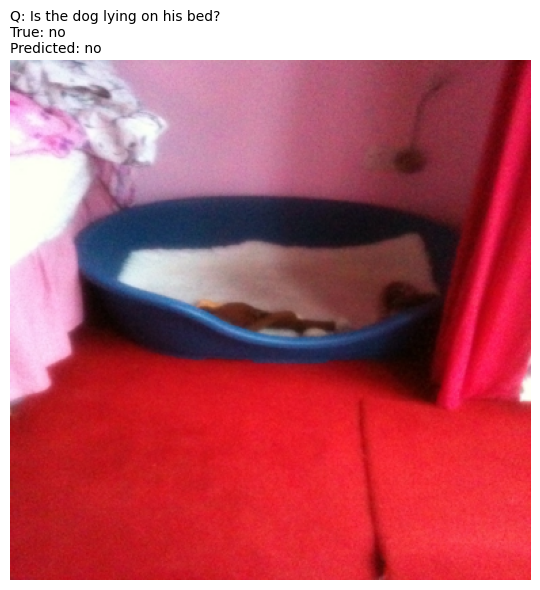

 10%|█         | 1/10 [00:05<00:52,  5.86s/it]

Image: VizWiz_train_00001327.jpg
Question: It is black?
✅ True Label:      yes
🤖 Predicted Label: no
------------------------------------------------------------


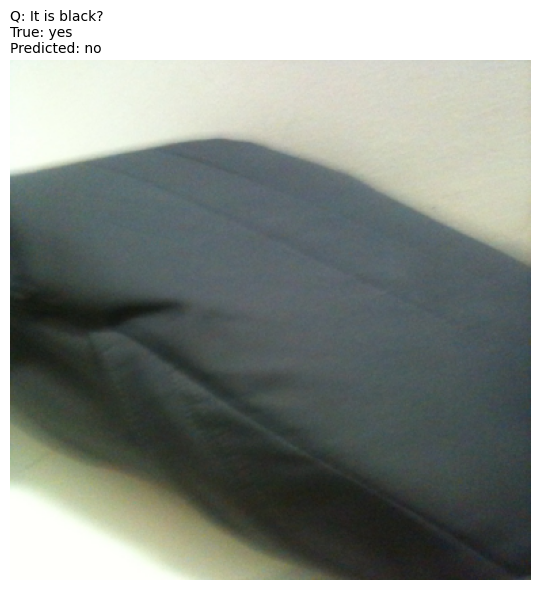

 20%|██        | 2/10 [00:08<00:30,  3.82s/it]

Image: VizWiz_train_00014073.jpg
Question: is there anything on the screen
✅ True Label:      yes
🤖 Predicted Label: yes
------------------------------------------------------------


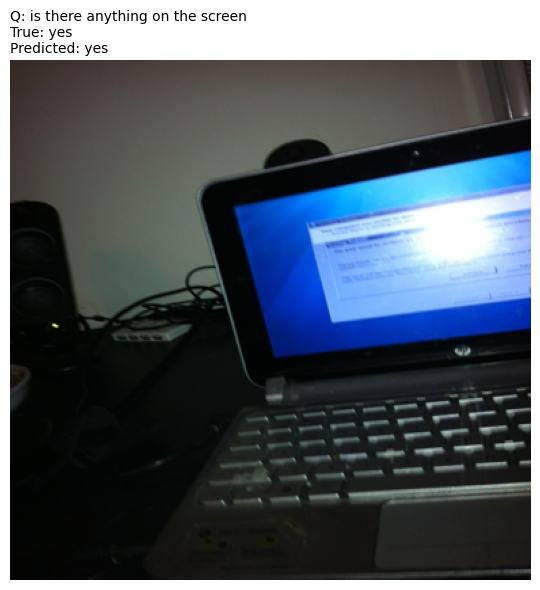

 30%|███       | 3/10 [00:10<00:22,  3.16s/it]

Image: VizWiz_train_00011858.jpg
Question: Can you see the box now?
✅ True Label:      no
🤖 Predicted Label: no
------------------------------------------------------------


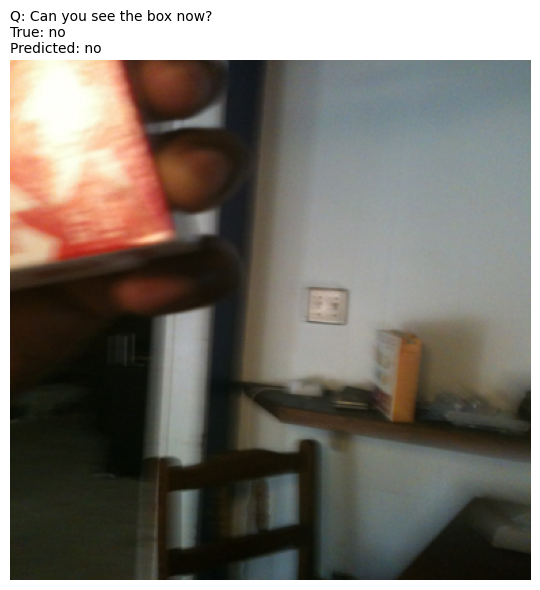

 40%|████      | 4/10 [00:13<00:17,  2.86s/it]

Image: VizWiz_train_00011142.jpg
Question: Are there shoes in the cupboard?
✅ True Label:      yes
🤖 Predicted Label: yes
------------------------------------------------------------


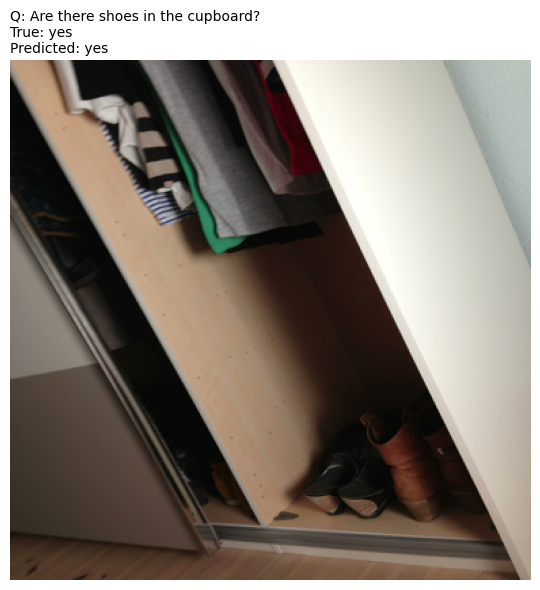

 50%|█████     | 5/10 [00:13<00:10,  2.05s/it]

Image: VizWiz_train_00007121.jpg
Question: Can you read this?
✅ True Label:      yes
🤖 Predicted Label: no
------------------------------------------------------------


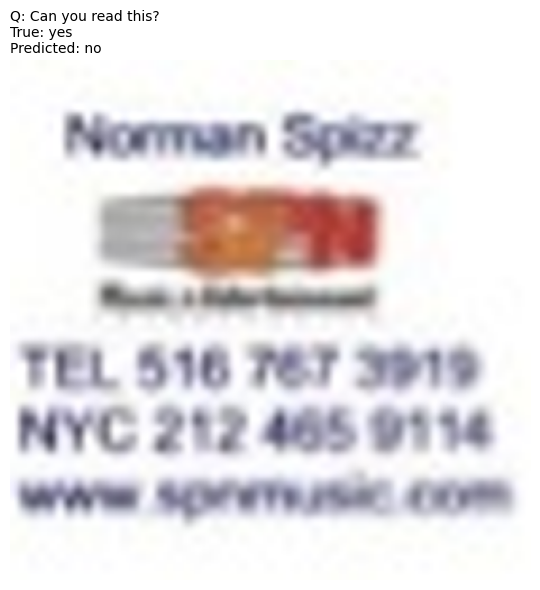

 60%|██████    | 6/10 [00:15<00:08,  2.12s/it]

Image: VizWiz_train_00005576.jpg
Question: Does this shirt and pants go together?
✅ True Label:      yes
🤖 Predicted Label: yes
------------------------------------------------------------


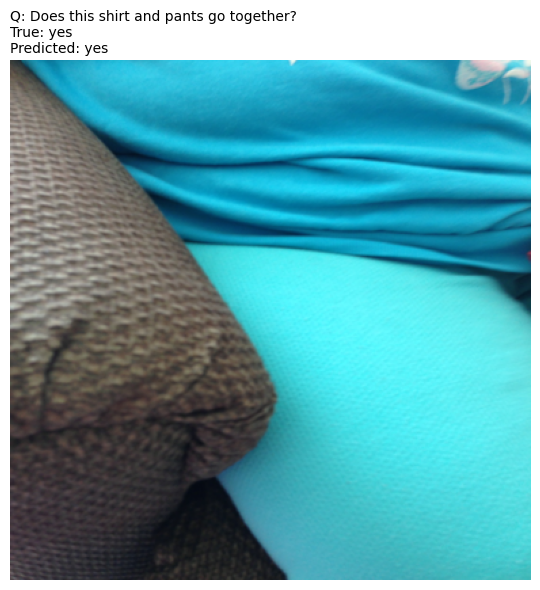

 70%|███████   | 7/10 [00:16<00:04,  1.65s/it]

Image: VizWiz_train_00004546.jpg
Question: Is this clam chowder?
✅ True Label:      yes
🤖 Predicted Label: yes
------------------------------------------------------------


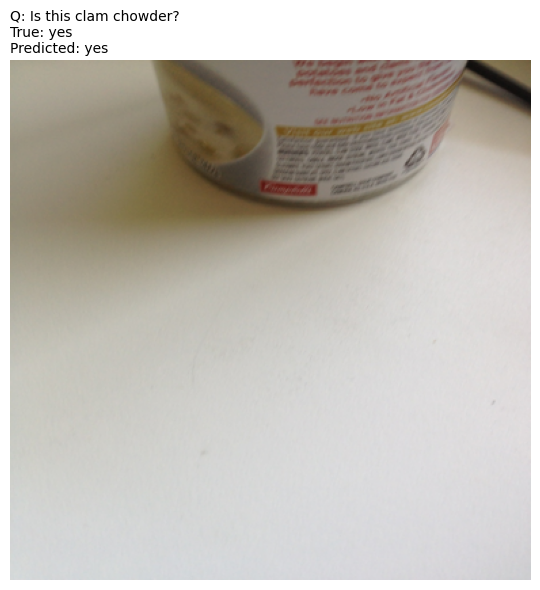

 80%|████████  | 8/10 [00:17<00:02,  1.33s/it]

Image: VizWiz_train_00023628.jpg
Question: Do i have to enter in a captcha?
✅ True Label:      no
🤖 Predicted Label: yes
------------------------------------------------------------


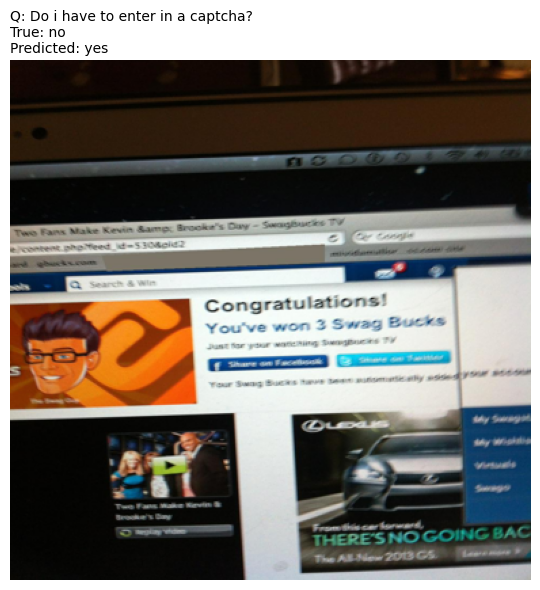

 90%|█████████ | 9/10 [00:19<00:01,  1.66s/it]

Image: VizWiz_train_00001659.jpg
Question: Are either one of these evaporated milk?
✅ True Label:      no
🤖 Predicted Label: no
------------------------------------------------------------


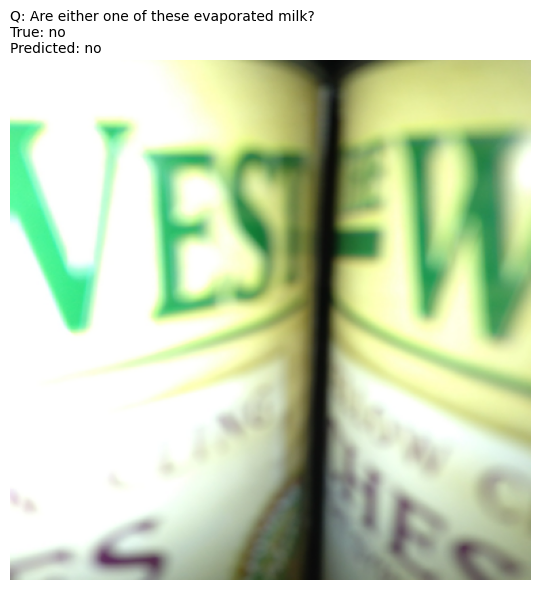

100%|██████████| 10/10 [00:20<00:00,  2.02s/it]


In [4]:
import os
import json
import torch
import numpy as np
from collections import Counter
from PIL import Image
from transformers import ViltProcessor, ViltForQuestionAnswering
from tqdm import tqdm
import matplotlib.pyplot as plt


# Set paths
model_path = "models/vilt_finetuned_vizwiz_ocr"
val_images_dir = "/Users/zagaraa/Documents/GitHub/visionaid-vqa/data/balanced_subset2/val/"
val_annotations_file = "/Users/zagaraa/Documents/GitHub/visionaid-vqa/data/balanced_subset2/annotations/val.json"

# Load model and processor
processor = ViltProcessor.from_pretrained(model_path)
model = ViltForQuestionAnswering.from_pretrained(model_path)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

# Load id2label and answer2id mapping
id2label = model.config.id2label
answer2id = {v.lower(): int(k) for k, v in id2label.items()}

# Load test annotations
with open(val_annotations_file, "r") as f:
    samples = json.load(f)

# Predict and print results
for sample in tqdm(samples[:10]):  # Adjust to all or a subset
    image_path = os.path.join(val_images_dir, sample["image"])
    image = Image.open(image_path).convert("RGB").resize((384, 384))
    question = sample["question"]

    # Prepare input
    inputs = processor(image, question, return_tensors="pt").to(device)
    
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_id = logits.argmax(-1).item()
        predicted_label = id2label.get(predicted_id, f"unknown_{predicted_id}").lower()


    # Ground truth (most common answer)
    answers = sample.get("answers", [])
    candidates = [a["answer"].strip().lower() for a in answers if a.get("answer", "").strip()]
    true_label = Counter(candidates).most_common(1)[0][0] if candidates else "unanswerable"

    print(f"Image: {sample['image']}")
    print(f"Question: {question}")
    print(f"✅ True Label:      {true_label}")
    print(f"🤖 Predicted Label: {predicted_label}")
    print("-" * 60)

# for sample in samples[:10]:  # Adjust range as needed
    image_path = os.path.join(val_images_dir, sample["image"])
    image = Image.open(image_path).convert("RGB").resize((384, 384))
    question = sample["question"]

    # Prepare input for ViLT
    inputs = processor(image, question, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_id = logits.argmax(-1).item()
        predicted_label = id2label.get(predicted_id, f"unknown_{predicted_id}").lower()

    # Extract the ground truth answer
    answers = sample.get("answers", [])
    candidates = [a["answer"].strip().lower() for a in answers if a.get("answer", "").strip()]
    true_label = Counter(candidates).most_common(1)[0][0] if candidates else "unanswerable"

    # 🖼️ Display image + info
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.title(
        f"Q: {question}\n"
        f"True: {true_label}\n"
        f"Predicted: {predicted_label}",
        fontsize=10,
        loc='left',
        wrap=True
    )
    plt.tight_layout()
    plt.show()

# BLIP2

In [8]:
!python scripts/inference_blip2.py --image /Users/zagaraa/Documents/GitHub/visionaid-vqa/data/vizwiz/test/VizWiz_test_00000299.jpg --question "What is this product?" --model_path /Users/zagaraa/Documents/GitHub/visionaid-vqa/models/local_blip2/

Loading checkpoint shards: 100%|██████████████████| 4/4 [00:02<00:00,  1.38it/s]
Question: What is this product?
Answer: niacin


# Florence-2

In [6]:
!python scripts/inference_florence2.py --image /Users/zagaraa/Documents/GitHub/visionaid-vqa/data/balanced_subset2/test/VizWiz_train_00000416.jpg

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/Users/zagaraa/Documents/GitHub/visionaid-vqa/vqa/lib/python3.9/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
Florence2LanguageForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin`

In [20]:
import os
import json
import random
import torch
import numpy as np
from collections import Counter, defaultdict
from PIL import Image
import pytesseract
import matplotlib.pyplot as plt
from tqdm import tqdm
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.tokenize import word_tokenize

# Disable tokenizer parallelism warning
os.environ["TOKENIZERS_PARALLELISM"] = "false"
# Set Tesseract path if needed (adjust if necessary)
pytesseract.pytesseract.tesseract_cmd = "/opt/homebrew/bin/tesseract"

# Download required NLTK resources (only needed once)
nltk.download('punkt')

from transformers import AutoModelForCausalLM, AutoProcessor, AutoConfig

# -------------------------------------------------
# Set paths (adjust these paths to your local setup)
# -------------------------------------------------
model_path = "models/florence2-finetuned"  # Local folder containing your fine-tuned Florence2 model
test_image_dir = "/Users/zagaraa/Documents/GitHub/visionaid-vqa/data/balanced_subset2/val/"
test_annotations_file = "/Users/zagaraa/Documents/GitHub/visionaid-vqa/data/balanced_subset2/annotations/val.json"

# -------------------------------------------------
# Load model configuration and override vision_config if necessary
# -------------------------------------------------
config = AutoConfig.from_pretrained(
    model_path,
    trust_remote_code=True,
    local_files_only=True
)
if getattr(config.vision_config, "model_type", None) != "davit":
    print(f"Overriding vision_config.model_type from {config.vision_config.model_type} to 'davit'")
    config.vision_config.model_type = "davit"

# -------------------------------------------------
# Load processor and model from the local directory
# -------------------------------------------------
processor = AutoProcessor.from_pretrained(
    model_path,
    trust_remote_code=True,
    local_files_only=True
)
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    config=config,
    trust_remote_code=True,
    local_files_only=True
)
model.eval()

# -------------------------------------------------
# Set device
# -------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# -------------------------------------------------
# Define VizWizDataset for evaluation
# -------------------------------------------------
class VizWizDataset(torch.utils.data.Dataset):
    """
    Loads VizWiz samples.
    
    Each sample:
      - Loads an image and resizes it to 384x384.
      - Extracts OCR text from the image.
      - Combines the raw question with OCR context.
      - Determines the reference answer (most common answer, or "unanswerable").
    """
    def __init__(self, image_dir, annotation_file, processor, max_length=128):
        with open(annotation_file, "r") as f:
            self.samples = json.load(f)
        self.image_dir = image_dir
        self.processor = processor
        self.max_length = max_length

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        image_path = os.path.join(self.image_dir, sample["image"])
        image = Image.open(image_path).convert("RGB").resize((384, 384))
        
        # Extract OCR text (fallback if empty)
        ocr_text = pytesseract.image_to_string(image).strip()
        ocr_text = " ".join(ocr_text.split()) if ocr_text else "no visible text"
        # Combine question with OCR context
        combined_question = f"{sample['question'].strip()} Context: {ocr_text}"
        
        # Compute reference answer as the most common answer (if available)
        answers = [a["answer"].strip().lower() for a in sample.get("answers", []) if a.get("answer", "").strip()]
        reference = Counter(answers).most_common(1)[0][0] if answers else "unanswerable"
        
        # Prepare inputs for the model
        inputs = self.processor(
            text=combined_question,
            images=image,
            return_tensors="pt",
            truncation=True,
            padding="max_length",
            max_length=self.max_length
        )
        # Remove extra batch dimension
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        inputs["reference"] = reference
        inputs["image_obj"] = image  # Keep the PIL image for display
        inputs["raw_question"] = sample["question"]
        return inputs

# -------------------------------------------------
# Build the dataset and select 10 random samples
# -------------------------------------------------
dataset = VizWizDataset(test_image_dir, test_annotations_file, processor, max_length=128)
num_samples = len(dataset)
num_to_display = 10
random_indices = random.sample(range(num_samples), num_to_display)

# -------------------------------------------------
# Evaluate selected samples and display results
# -------------------------------------------------
smoothing_fn = SmoothingFunction().method1  # For BLEU score (if needed)

for idx in random_indices:
    sample = dataset[idx]
    image = sample["image_obj"]
    raw_question = sample["raw_question"]
    reference = sample["reference"]
    
    # Prepare input for the model (add batch dimension)
    inputs = {k: sample[k].unsqueeze(0).to(device) for k in ["input_ids", "pixel_values"]}
    with torch.no_grad():
        generated_ids = model.generate(
            input_ids=inputs["input_ids"],
            pixel_values=inputs["pixel_values"],
            max_new_tokens=50,
            num_beams=3
        )
    predicted_label = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip().lower()
    
    # Print the evaluation details
    print(f"Index: {idx}")
    print(f"Question: {raw_question}")
    print(f"True Label: {reference}")
    print(f"Predicted Label: {predicted_label}")
    print("-" * 60)
    
    # Display the image with evaluation details using Matplotlib
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis("off")
    plt.title(
        f"Q: {raw_question}\nTrue: {reference}\nPred: {predicted_label}",
        fontsize=10
    )
    plt.tight_layout()
    plt.show()

[nltk_data] Downloading package punkt to /Users/zagaraa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Overriding vision_config.model_type from  to 'davit'


OverflowError: can't convert negative int to unsigned